In [13]:
import pandas as pd
import chardet
import gensim
from gensim.models import Word2Vec
import time;
import sys;
import multiprocessing;

def read_file(filename):
    colnames=['id', 'seq', 'name1', 'name2', 'name3', 'text'] 
    with open(filename, 'rb') as f:
        result = chardet.detect(f.read())  # or readline if the file is large
    table = pd.read_csv(filename,  encoding = result['encoding'], delimiter = ',', names=colnames, header=None)
    return table

def read_conference_call(year):
    print("reading data for year ", year)
    path = "data/"+ str(year)+ "_processed/eventPresentation.csv"
    df  = read_file(path)
    rawTexts = df.dropna(subset=['text'])['text']
    sentences = [gensim.utils.simple_preprocess(x)  for x in  rawTexts.tolist()]
    print("read year ", year, " and get ", len(sentences), " sentences")
    return sentences


def word2vec_increment_train(year):
    start = time.time();
    sentences = read_conference_call(year) 
    if (year > 2001):
        model_name = "model_even_presentation_" + str(year-1);
        model = Word2Vec.load(model_name)
        print('loaded old model from ', model_name)
    model.build_vocab(sentences, update=True)
    model.train(sentences,  total_examples = len(sentences), epochs = model.epochs)
    print('Total time: ' + str((time.time() - start)) + ' secs for year ' + str(year) )
    
    # Save the newly trained model
    model_name = "model_even_presentation_" + str(year);
    model.save(model_name);
    print(model)


    

## Train word2vec using event presentation of 2001 to 2018 conference call transcrit

## initial word2vec training using data from 2001

In [6]:
# train 2001
sentences = read_conference_call(2001)

start = time.time();
model = Word2Vec(sentences, size=100, window=10, min_count=10, workers=multiprocessing.cpu_count())

# Save the model
model_name = "model_even_presentation_" + str(2001);
model.save(model_name);
print(model)
print('Total time: ' + str((time.time() - start)) + ' secs')

reading data for year  2001
read year  2001  and get  49030  sentences
Word2Vec(vocab=10508, size=100, alpha=0.025)
Total time: 10.573856115341187 secs


## online training using data from 2002 - 2018

In [15]:
for year in range(2002, 2019):
    print("training with data from year ", year)
    word2vec_increment_train(year)

training with data from year  2002
reading data for year  2002
read year  2002  and get  529916  sentences
loaded old model from  model_even_presentation_2001
Total time: 173.99247694015503 secs for year 2002
Word2Vec(vocab=32243, size=100, alpha=0.025)
training with data from year  2003
reading data for year  2003
read year  2003  and get  502434  sentences
loaded old model from  model_even_presentation_2002
Total time: 243.32029604911804 secs for year 2003
Word2Vec(vocab=40547, size=100, alpha=0.025)
training with data from year  2004
reading data for year  2004
read year  2004  and get  466756  sentences
loaded old model from  model_even_presentation_2003
Total time: 267.5762372016907 secs for year 2004
Word2Vec(vocab=44496, size=100, alpha=0.025)
training with data from year  2005
reading data for year  2005
read year  2005  and get  136191  sentences
loaded old model from  model_even_presentation_2004
Total time: 261.6704947948456 secs for year 2005
Word2Vec(vocab=53147, size=100,

## check the trained word2vec model

In [16]:
model_name = "model_even_presentation_2018"
model = Word2Vec.load(model_name)

print(model)

Word2Vec(vocab=101921, size=100, alpha=0.025)


In [17]:
w1 = "income"
model.wv.most_similar (positive=w1)

[('profit', 0.7590484619140625),
 ('loss', 0.6888387203216553),
 ('profits', 0.6309934854507446),
 ('expense', 0.606441855430603),
 ('expenses', 0.594470739364624),
 ('earnings', 0.5857782959938049),
 ('losses', 0.5803841352462769),
 ('incomes', 0.566402792930603),
 ('nii', 0.5352892875671387),
 ('revenues', 0.5227659940719604)]

In [24]:
from sklearn.cluster import KMeans;
def clustering_on_wordvecs(word_vectors, num_clusters):
    # Initalize a k-means object and use it to extract centroids
    kmeans_clustering = KMeans(n_clusters = num_clusters, init='k-means++');
    idx = kmeans_clustering.fit_predict(word_vectors);
    
    return kmeans_clustering.cluster_centers_, idx;

In [22]:
Z = model.wv.vectors;
print(Z[0].shape)
Z[0]

(100,)


array([ 1.2709848 ,  0.36381263,  2.7701378 , -0.12123864, -1.2746164 ,
        2.3644295 ,  0.14058936,  1.3703244 , -0.22504659, -0.9565653 ,
        1.6223894 , -0.10687794, -0.60241455, -0.7423016 , -0.12142756,
        1.6866518 , -1.4205763 , -0.35683224,  0.78944343,  0.13448572,
        1.5633112 , -1.7051145 , -2.7217262 ,  1.0522974 ,  1.0063144 ,
       -0.13577686,  0.53829086,  0.34341848, -1.4545268 ,  0.13537757,
       -1.2304747 ,  0.7044294 ,  0.3403678 ,  0.03457992, -0.18655537,
        0.7658107 , -0.5083553 ,  0.1874866 , -0.2738705 ,  2.6641595 ,
       -0.62377435, -1.4624022 ,  0.2149364 , -1.6771408 ,  2.441426  ,
        0.726835  ,  1.1817517 ,  0.18916766, -1.997528  ,  0.2669035 ,
        1.8291851 ,  1.3493104 , -3.3203409 , -0.31188223,  1.8314798 ,
        1.5968851 , -0.48329496, -1.4379059 , -0.88756275,  1.208047  ,
        0.55147344,  0.31889066, -0.4012333 ,  1.1844598 ,  0.05419073,
        1.1070229 ,  1.7448012 ,  1.1331716 ,  1.8268129 ,  2.13

In [25]:
start = time.time();
centers, clusters = clustering_on_wordvecs(Z, 50);
print('Total time: ' + str((time.time() - start)) + ' secs')

Total time: 73.31044030189514 secs


In [26]:
start = time.time();
centroid_map = dict(zip(model.wv.index2word, clusters));
print('Total time: ' + str((time.time() - start)) + ' secs')

Total time: 0.03645896911621094 secs


In [31]:
from sklearn.neighbors import KDTree;
import numpy as np;
def get_top_words(index2word, k, centers, wordvecs):
    tree = KDTree(wordvecs);

    #Closest points for each Cluster center is used to query the closest 20 points to it.
    closest_points = [tree.query(np.reshape(x, (1, -1)), k=k) for x in centers];
    closest_words_idxs = [x[1] for x in closest_points];

    #Word Index is queried for each position in the above array, and added to a Dictionary.
    closest_words = {};
    for i in range(0, len(closest_words_idxs)):
        closest_words['Cluster #' + str(i+1).zfill(2)] = [index2word[j] for j in closest_words_idxs[i][0]]

    #A DataFrame is generated from the dictionary.
    df = pd.DataFrame(closest_words);
    df.index = df.index+1

    return df;

In [32]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
top_words = get_top_words(model.wv.index2word, 20, centers, Z);

In [33]:
top_words

,Cluster #01,Cluster #02,Cluster #03,Cluster #04,Cluster #05,Cluster #06,Cluster #07,Cluster #08,Cluster #09,Cluster #10,Cluster #11,Cluster #12,Cluster #13,Cluster #14,Cluster #15,Cluster #16,Cluster #17,Cluster #18,Cluster #19,Cluster #20,Cluster #21,Cluster #22,Cluster #23,Cluster #24,Cluster #25,Cluster #26,Cluster #27,Cluster #28,Cluster #29,Cluster #30,Cluster #31,Cluster #32,Cluster #33,Cluster #34,Cluster #35,Cluster #36,Cluster #37,Cluster #38,Cluster #39,Cluster #40,Cluster #41,Cluster #42,Cluster #43,Cluster #44,Cluster #45,Cluster #46,Cluster #47,Cluster #48,Cluster #49,Cluster #50
1,defeased,mettoni,octal,fleshed,unfairness,prialt,sharefile,hemorrhage,resistive,bloomingdales,antony,holman,giddings,polyols,turndown,reconfirms,imbalanced,orienting,ravi,comac,bling,postcards,vets,derecognition,steeped,volga,idenix,factsheet,perpetuate,ocrelizumab,intracellular,finalised,massmutual,midamerican,backhauling,prosthesis,amarillos,housings,contexts,berths,creditanstalt,syrups,vided,dipyridamole,skirt,brentwood,kdg,lumwana,prosecutors,smash
2,unguaranteed,deventure,xrs,eke,unworkable,androgel,clm,asymptomatic,touchscreens,levis,macciacchini,fleischer,subsalt,pulps,droughts,embeds,constricted,recalibrating,amar,learjet,rebelle,blogging,fellowship,noneconomic,innovates,moldova,micromet,tweeting,utilise,elotuzumab,cyp,intimated,schroders,biomethane,dongles,cryoablation,kfs,hoses,histologies,bulker,ugf,pastry,nunnelee,tanezumab,slippers,oakville,altel,agbaou,legality,skateboarding
3,mez,axip,emulator,trickling,overreaching,formoterol,wfo,neurologic,stepper,dillards,mahmoud,devlin,triassic,zirconium,fragility,amplifies,lethargic,devising,sandro,cockpits,curl,newsfeed,aides,remeasurements,empathetic,cordoba,progenics,greendot,amass,idelalisib,metabolites,telegraphed,dlj,fortisbc,multicast,guidewires,oyong,couplings,oncogenes,vlgcs,sabanci,cheeses,ppifs,kepivance,backpacks,gables,telephonica,maricunga,whistleblower,terminator
4,obligors,nedstat,phaser,sucked,intimidated,antifungal,thingworx,embolism,pmic,topshop,yaacov,mandel,updip,bleaching,paralysis,inflates,lukewarm,purposing,patrice,airframes,tagless,podcasts,subspecialty,remeasuring,imaginative,ankara,stiefel,jessa,fulfil,elesclomol,micrornas,utilised,tcg,transwestern,femtocell,duragen,paredones,saws,permutations,supramaxes,compagnie,sweets,disbarment,nvc,panty,saginaw,suncom,cienega,injunctions,soundtrack
5,tlgp,biofocus,hdwire,ripped,unconscionable,xenazine,orchestrator,bleeds,lrdimm,homesense,castellucci,rohde,pel,phosphorous,negativity,obscures,precarious,reorienting,jenniffer,cseries,bridesmaids,trueview,outpatients,pvm,tenacious,kosovo,eyetech,cnmv,recuperate,ponesimod,epigenetic,instigated,financier,coned,ebdo,thoracolumbar,klondike,blowers,workstreams,layup,urquijo,toasted,auditee,demyelination,sneaker,fredericksburg,globecast,centinela,affirmatively,finale
6,mtns,calence,opencl,wiping,outraged,levaquin,nimsoft,dysplasia,miniaturized,athleta,christiane,wilde,redoubt,ethers,adversities,ignores,unhelpful,purposed,nicky,striker,piperlime,uploads,chiropractic,bfg,engrained,villahermosa,pharmacopeia,globenewswire,disperse,fludarabine,phenotype,operationalized,kirshenbaum,mitsue,xdsl,sutures,prd,nozzle,landmarks,tows,finanziario,muffins,lihtcs,eluxadoline,khaki,morristown,unitymedia,saucito,ofac,dragons
7,repricings,hardi,vtms,snapped,destabilized,oxybutynin,dynatrace,hypertensive,oscillators,gordmans,larisa,pollack,mannville,billets,thunderstorms,magnifies,shortsighted,strategizing,dorothy,mrj,ruffles,texts,optometrists,ocps,possessed,medellin,trubion,nzx,reorient,abiraterone,adenoviral,tabled,socgen,manchief,fttc,cranial,batangas,nozzles,commonalities,kamsarmax,servicios,pastas,suballocated,granisetron,totes,uptown,moviles,akyem,arbitrators,penguins
8,hmbs,hwada,xfd,straighten,perpetuated,intuniv,itsm,hyperglycemia,tsv,carters,lui,geist,recomplete,emulsions,unseasonal,delineates,exuberant,igniting,martyn,lav,anthropology,widget,hospitalists,tcja,linchpin,lagos,dey,tse,mag

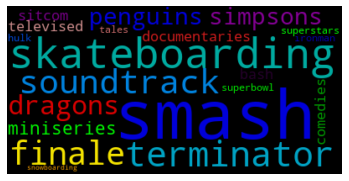

In [37]:
from wordcloud import WordCloud, ImageColorGenerator
from itertools import cycle;
import matplotlib.pyplot as plt;
def display_cloud(cluster_num, cmap):
    wc = WordCloud(background_color="black", max_words=2000, max_font_size=80, colormap=cmap);
    wordcloud = wc.generate(' '.join([word for word in top_words['Cluster #' + str(cluster_num).zfill(2)]]))

    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.savefig('cluster_' + str(cluster_num), bbox_inches='tight')

cmaps = cycle([
            'flag', 'prism', 'ocean', 'gist_earth', 'terrain', 'gist_stern',
            'gnuplot', 'gnuplot2', 'CMRmap', 'cubehelix', 'brg', 'hsv',
            'gist_rainbow', 'rainbow', 'jet', 'nipy_spectral', 'gist_ncar'])

for i in range(50):
    col = next(cmaps);
    display_cloud(i+1, col)
    

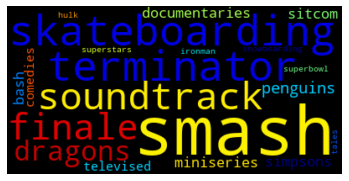

In [38]:
for i in range(50):
    col = next(cmaps);
    display_cloud(i+1, col)

In [2]:
df_2001_eventPresentation  = read_file("data/2001_processed/eventPresentation.csv")
df_2001_eventPresentation.head(5)

,id,seq,name1,name2,name3,text
0,104904.F,1,Editor [1],Editor,Editor [1],PAYCHEX'S THIRD QUARTER PRESS RELEASE
1,104904.F,2,Operator [2],Operator,Operator [2],"Good morning, and welcome ladies and gentlemen..."
2,104904.F,3,JOHN M. MORPHY,"JOHN M. MORPHY,",[3],Thank-you for joining us for our third quarter...
3,104904.F,4,THOMAS B. GOLISANO,"THOMAS B. GOLISANO,",[4],"Good morning everybody. A couple of comments, ..."
4,104904.F,5,JOHN M. MORPHY,"JOHN M. MORPHY,",[5],Anna?
5,104904.F,6,Operator [6],Operator,Operator [6],Yes Sir. The question and answer session will ...
6,104904.F,7,PATRICK M. BURTON,"PATRICK M. BURTON,",[7],Hi! Salomon Smith Barney. It would appear Tom ...
7,104904.F,8,THOMAS B. GOLISANO,"THOMAS B. GOLISANO,",[8],"As far as the outlook for going forward, I thi..."
8,104904.F,9,PATRICK M. BURTON,"PATRICK M. BURTON,",[9],What percentage as a followup of that revenue ...
9,104904.F,10,THOMAS B. GOLISANO,"THOMAS B. GOLISANO,",[10],Somewhere between 25 and 30 would be graduatin...


In [3]:
df_2001_eventQA  = read_file("data/2001_processed/eventQ&A.csv")
df_2001_eventQA.head(5)

,id,seq,name1,name2,name3,text
0,104904.F,1,Editor [1],Editor,Editor [1],PAYCHEX'S THIRD QUARTER PRESS RELEASE
1,104904.F,2,Operator [2],Operator,Operator [2],"Good morning, and welcome ladies and gentlemen..."
2,104904.F,3,JOHN M. MORPHY,"JOHN M. MORPHY,",[3],Thank-you for joining us for our third quarter...
3,104904.F,4,THOMAS B. GOLISANO,"THOMAS B. GOLISANO,",[4],"Good morning everybody. A couple of comments, ..."
4,104904.F,5,JOHN M. MORPHY,"JOHN M. MORPHY,",[5],Anna?
5,104904.F,6,Operator [6],Operator,Operator [6],Yes Sir. The question and answer session will ...
6,104904.F,7,PATRICK M. BURTON,"PATRICK M. BURTON,",[7],Hi! Salomon Smith Barney. It would appear Tom ...
7,104904.F,8,THOMAS B. GOLISANO,"THOMAS B. GOLISANO,",[8],"As far as the outlook for going forward, I thi..."
8,104904.F,9,PATRICK M. BURTON,"PATRICK M. BURTON,",[9],What percentage as a followup of that revenue ...
9,104904.F,10,THOMAS B. GOLISANO,"THOMAS B. GOLISANO,",[10],Somewhere between 25 and 30 would be graduatin...


In [32]:
import gensim
from gensim.models import Word2Vec
from sklearn.decomposition import PCA
from matplotlib import pyplot

In [26]:
# remove rows with nan value from text field
rawTexts = df_2001_eventQA.dropna(subset=['text'])['text']

In [39]:
sentences = [gensim.utils.simple_preprocess(x)  for x in  rawTexts.tolist()]

In [63]:
len(sentences)

578946

In [43]:
model = Word2Vec(sentences, size=300, window=10, min_count=2, workers=10)
print(model)

Word2Vec(vocab=25074, size=300, alpha=0.025)


## Test to see the trained model actually make sense, we search for similar words of income

In [49]:
w1 = "income"
model.wv.most_similar (positive=w1)

[('profit', 0.6804419755935669),
 ('loss', 0.6471255421638489),
 ('expense', 0.64226895570755),
 ('profits', 0.6392098665237427),
 ('premiums', 0.6192280054092407),
 ('earnings', 0.5872069597244263),
 ('losses', 0.5751500129699707),
 ('taxes', 0.5638076066970825),
 ('expenses', 0.5587404370307922),
 ('minority', 0.5546191930770874)]

In [51]:
# similarity between two different words
model.wv.similarity(w1="income",w2="earnings")

0.58720696

/Users/Xuan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


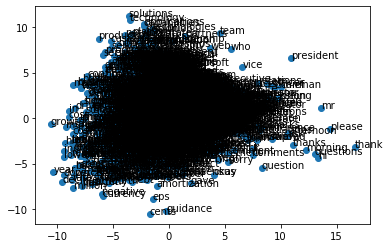

In [44]:
# fit a 2d PCA model to the vectors
X = model[model.wv.vocab]
pca = PCA(n_components=2)
result = pca.fit_transform(X)
# create a scatter plot of the projection
pyplot.scatter(result[:, 0], result[:, 1])
words = list(model.wv.vocab)
for i, word in enumerate(words):
	pyplot.annotate(word, xy=(result[i, 0], result[i, 1]))
pyplot.show()